# Figure 3: Assessing thew Stability of Meta-analyses through Repeated Subsampling
## Subsamples were rather arbitrarily set to (N = 50, N =  0.2 * Ndomain). Using fixed and proportional N favors smaller and larger (sub)BDs, respectively.
## Hence, we also using a sliding proportion approach to see how stability increased as effect of proportion within a (sub)BD.


#### Author: Neville Magielse
#### Date: 29.07.2024

In [58]:
# Imports
import nimare
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import nilearn.plotting, nilearn.maskers
import nibabel
import sys
import SUITPy
import SUITPy.flatmap as flatmap
from nimare.meta.cbma.ale import ALE
from nimare.correct import FWECorrector
from tqdm import tqdm

# Font style
plt.rcParams["font.family"] = "Asana Math"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 192


# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

# Order BDs by their sample size for plotting.

In [4]:
BDs = ['Action', 'Cognition', 'Emotion', 'Interoception',  'Perception']

In [5]:
# Add the number of experiments:
BDs_exps = {
    'Action': 583,
    'Cognition': 1522,
    'Emotion': 420,
    'Interoception': 124,
    'Perception': 652
}

In [6]:
BDs_order = pd.Series(BDs_exps).sort_values().index

In [16]:
# For the 0.2-proportional subsampling, add the number of experiments from the total (for plotting).
BDs_exps_sample = {
    'Action': 117,
    'Cognition': 304,
    'Emotion': 84,
    'Interoception': 25,
    'Perception': 130
}

# First, 50 experiments per subsample.
## For each step, we will just get the necessary data. The plotting of the figures in this notebook should thus be modular. :) 

In [7]:
# Open dictionaries, we will keep overwriting these throughout this notebook.
zmaps = {}
surf_zmaps = {}
corrs = {}
corrs_tril = {}

In [8]:
# Import data for each BD
analysis = 'SALE'
zmaps[analysis] = {}
surf_zmaps[analysis] = {}
for bd in BDs:
    zmaps[analysis][bd] = []
    surf_zmaps[analysis][bd] = []
    subsamples_dir = os.path.join(OUTPUT_DIR, analysis, bd, bd, 'subsamples')
    for subsample in tqdm(range(50)):
        zmap_path = os.path.join(subsamples_dir, str(subsample), 'uncorr_z.nii.gz') # For boxplot visualisation, highlighting correlation between full, unthresholded z-maps is most revealing.
        zmaps[analysis][bd].append(nibabel.load(zmap_path))
        surf_zmaps[analysis][bd].append(SUITPy.flatmap.vol_to_surf(zmap_path, space = 'SPM').squeeze()) # Space set to 'SPM' to match the BrainMap database.
    surf_zmaps[analysis][bd] = np.array(surf_zmaps[analysis][bd])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.70it/s]


In [9]:
corrs[analysis] = {}
corrs_tril[analysis] = {}
for bd in BDs:
    corrs[analysis][bd] = np.corrcoef(surf_zmaps[analysis][bd])
    corrs_tril[analysis][bd] = corrs[analysis][bd][np.tril_indices(50, -1)]

In [10]:
corrs_long = pd.DataFrame(corrs_tril[analysis]).unstack().reset_index()
corrs_long.columns = ['BD', 'pair', 'corr']

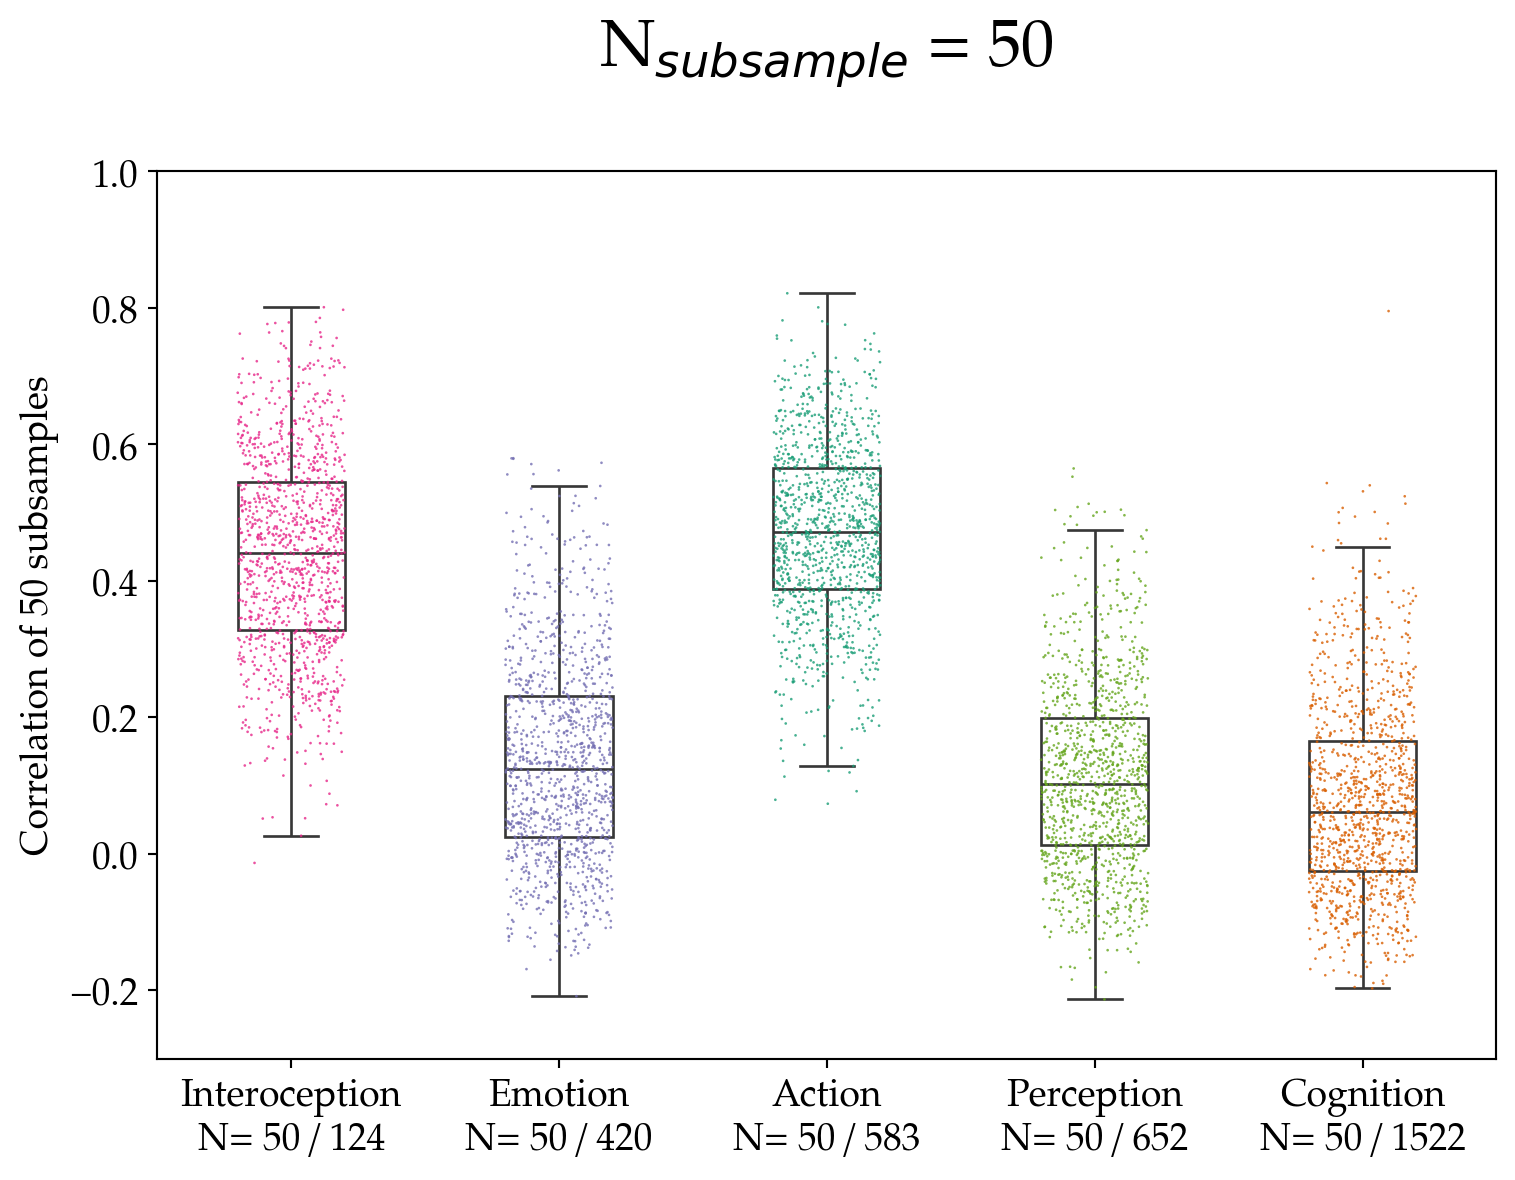

In [11]:
# Boxplots for within-BD spatial correlations of subsamples (N = 50).

# Create a new figure
fig, ax = plt.subplots(figsize=(9, 6))

# Make the background transparent
fig.patch.set_facecolor('none')

# Make the background of plotting area transparent
ax.patch.set_facecolor('none')

# Use the first 5 colors from the Dark2 colormap
colors = sns.color_palette("Dark2", n_colors=5)

sns.stripplot(data=corrs_long, x='BD', y='corr', 
              order=BDs_order, jitter=0.2,
              s=1, alpha=0.8, ax=ax, hue='BD', palette=colors, legend=False) # Chose quite a high alpha to have poppy colors.
sns.boxplot(data=corrs_long, x='BD', y='corr',
            order=BDs_order,
            showfliers=False, showcaps=True, width=0.4,
            boxprops={"facecolor": (1, 1, 1, 1)}, ax=ax, hue='BD', palette=colors, legend=False)
ax.set_xlabel('')
ax.set_ylabel('Correlation of 50 subsamples')
ax.set_title('N$_{subsample}$ = 50', y=1.1, fontsize=25)

# Create x-axis labels for BDs with sample size information.
ax.set_xticks(range(len(BDs_order)))
ax.set_xticklabels([f'{BD}\nN= 50 / {BDs_exps[BD]}' for BD in BDs_order], rotation=0, ha='center')

ax.set_ylim([-0.3, 1])

plt.show()


In [15]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Stability_analyses/Figure3/Domains_SpatialCorrelations_N50.png'), bbox_inches='tight')

# Then, the 0.2-proportion subsampling for the BDs.

In [18]:
# Import data
analysis = 'SALE'
zmaps[analysis] = {}
surf_zmaps[analysis] = {}
for bd in BDs:
    zmaps[analysis][bd] = []
    surf_zmaps[analysis][bd] = []
    subsamples_dir = os.path.join(OUTPUT_DIR, analysis, bd, bd, 'subsamples_p-02')
    for subsample in tqdm(range(50)):
        zmap_path = os.path.join(subsamples_dir, str(subsample), 'uncorr_z.nii.gz')
        zmaps[analysis][bd].append(nibabel.load(zmap_path))
        surf_zmaps[analysis][bd].append(SUITPy.flatmap.vol_to_surf(zmap_path, space = 'SPM').squeeze()) # Space to match BrainMap.
    surf_zmaps[analysis][bd] = np.array(surf_zmaps[analysis][bd])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.35it/s]


In [21]:
corrs[analysis] = {}
corrs_tril[analysis] = {}
for bd in BDs:
    corrs[analysis][bd] = np.corrcoef(surf_zmaps[analysis][bd])
    corrs_tril[analysis][bd] = corrs[analysis][bd][np.tril_indices(50, -1)]

In [22]:
corrs_long = pd.DataFrame(corrs_tril[analysis]).unstack().reset_index()
corrs_long.columns = ['BD', 'pair', 'corr']

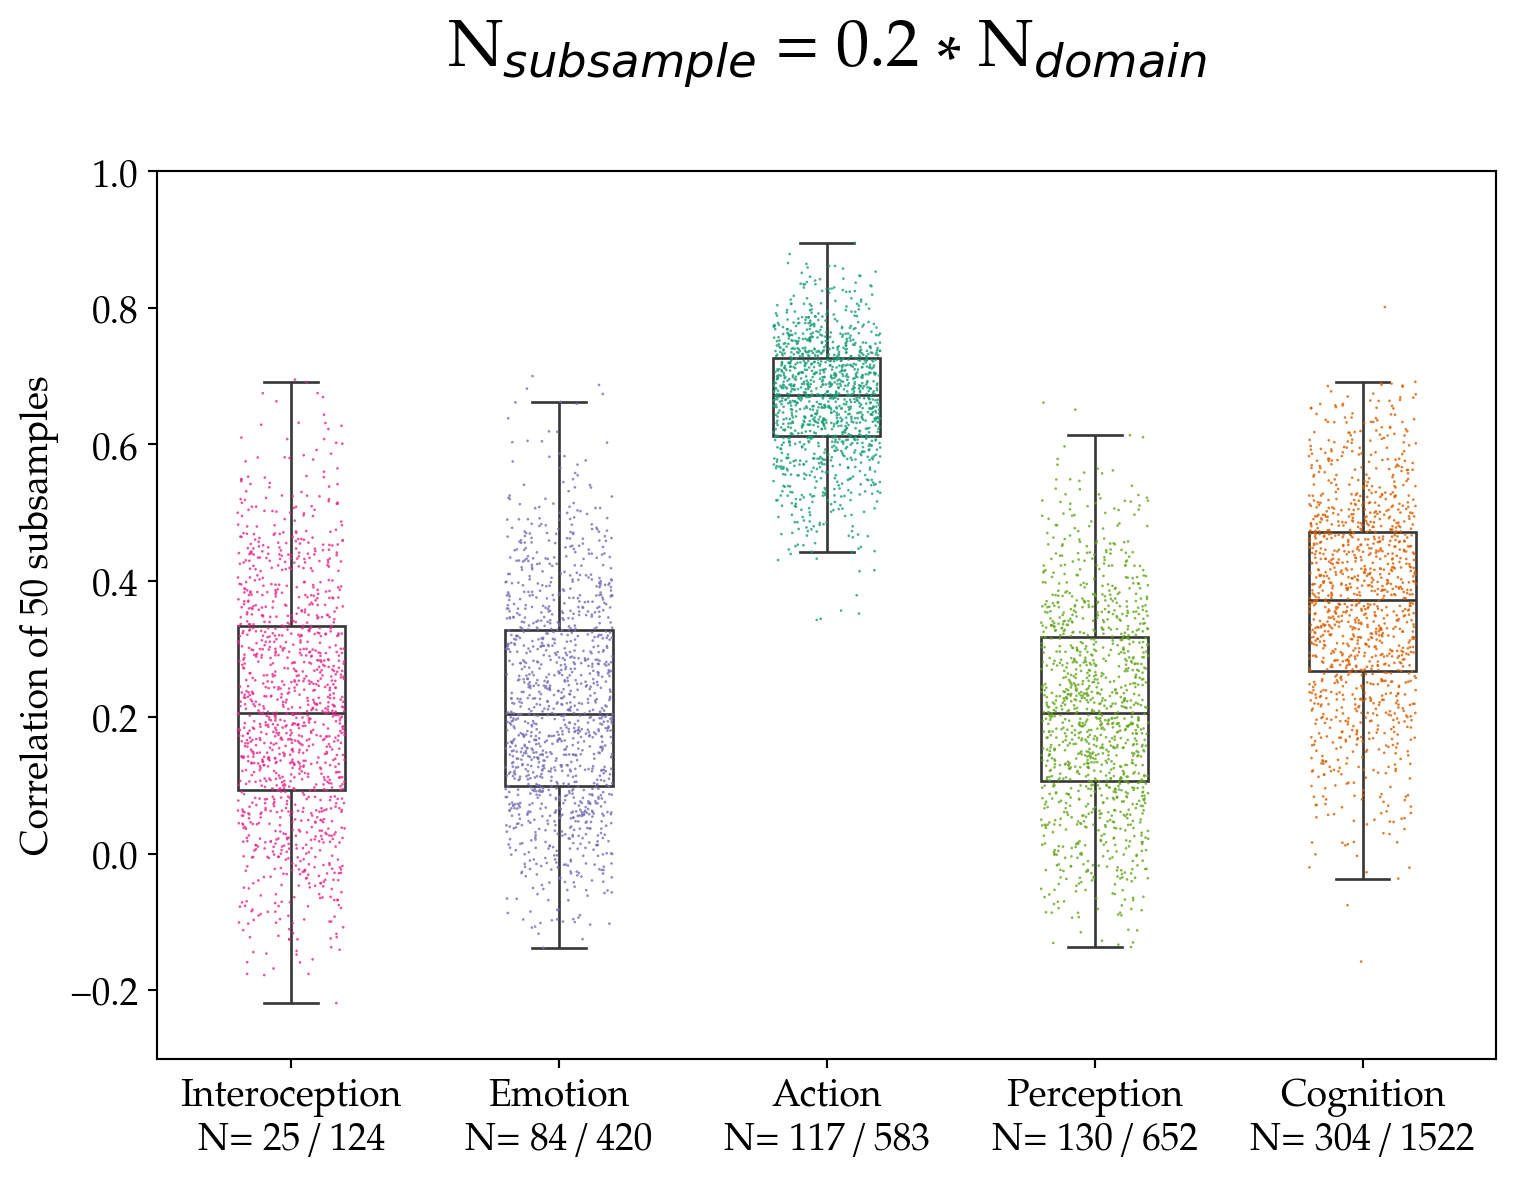

In [23]:
# Create a new figure
fig, ax = plt.subplots(figsize=(9, 6))

# Make the background transparent
fig.patch.set_facecolor('none')

# Make the background of plotting area transparent
ax.patch.set_facecolor('none')

# Use the first 5 colors from the Dark2 colormap
colors = sns.color_palette("Dark2", n_colors=5)

sns.stripplot(data=corrs_long, x='BD', y='corr', 
              order=BDs_order, jitter=0.2,
              s=1, alpha=0.8, ax=ax, hue='BD', palette=colors, legend=False)
sns.boxplot(data=corrs_long, x='BD', y='corr',
            order=BDs_order,
            showfliers=False, showcaps=True, width=0.4,
            boxprops={"facecolor": (1, 1, 1, 1)}, ax=ax, hue='BD', palette=colors, legend=False)
ax.set_xlabel('')
ax.set_ylabel('Correlation of 50 subsamples')
ax.set_title('N$_{subsample}$ = 0.2 * N$_{domain}$', y=1.1, fontsize=25)

# Add x-axis labels with subsample size information.
ax.set_xticks(range(len(BDs_order)))
ax.set_xticklabels([f'{BD}\nN= {BDs_exps_sample[BD]} / {BDs_exps[BD]}' for BD in BDs_order], rotation=0, ha='center')

ax.set_ylim([-0.3, 1])

plt.show()

In [24]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Stability_analyses/Figure3/Domains_SpatialCorrelations_p02.png'), bbox_inches='tight')

# Next up are the subdomains.
### Note that not all subdomains were subsampled. We only performed this analysis for subdomains with Nexperiments > 100, to assure they are of appropriate size. (100 * 0.2 = 20, which should allow for stable MA)

In [25]:
subdomains = ['Action.Execution', 'Cognition.Attention', 'Cognition.Language', 'Cognition.Language.Semantics', 'Cognition.Language.Speech', 'Cognition.Memory', 'Cognition.Memory.Explicit', 'Cognition.Memory.Working', 'Cognition.Reasoning', 'Emotion.Negative','Emotion.Positive', 'Emotion.Positive.RewardGain', 'Perception.Audition', 'Perception.Somesthesis', 'Perception.Somesthesis.Pain', 'Perception.Vision', 'Perception.Vision.Shape'] 

In [28]:
# Add the number of experiments:
subdomains_exps = {'Action.Execution': 444, 
'Cognition.Attention':443, 'Cognition.Language': 433 , 'Cognition.Language.Semantics': 250, 'Cognition.Language.Speech': 186, 
'Cognition.Memory': 402, 'Cognition.Memory.Explicit': 188, 'Cognition.Memory.Working': 200, 'Cognition.Reasoning': 212, 
'Emotion.Negative': 198 ,'Emotion.Positive': 254, 'Emotion.Positive.RewardGain': 163, 
'Perception.Audition': 114, 'Perception.Somesthesis': 150, 'Perception.Somesthesis.Pain': 105, 'Perception.Vision': 338, 'Perception.Vision.Shape' : 125

}                                      

In [30]:
subdomains_order = pd.Series(subdomains_exps).sort_values().index

In [42]:
# Add the number of experiments for the 0.2 proportion subdomains:
subdomains_exps_sample = {'Action.Execution': 89, 
'Cognition.Attention':89, 'Cognition.Language': 87 , 'Cognition.Language.Semantics': 50, 'Cognition.Language.Speech': 37, 
'Cognition.Memory': 80, 'Cognition.Memory.Explicit': 38, 'Cognition.Memory.Working': 40, 'Cognition.Reasoning': 42, 
'Emotion.Negative': 40 ,'Emotion.Positive': 51, 'Emotion.Positive.RewardGain': 33, 
'Perception.Audition': 23, 'Perception.Somesthesis': 30, 'Perception.Somesthesis.Pain': 21, 'Perception.Vision': 68, 'Perception.Vision.Shape' : 25
  
}

In [29]:
# Add nicer labels 
subdomains_labels = {'Action.Execution': 'Execution', 
'Cognition.Attention': 'Attention', 'Cognition.Language': 'Language' , 'Cognition.Language.Semantics': 'Semantics', 'Cognition.Language.Speech': 'Speech', 
'Cognition.Memory': 'Memory', 'Cognition.Memory.Explicit': 'Explicit Memory', 'Cognition.Memory.Working': 'Working Memory', 'Cognition.Reasoning': 'Reasoning', 
'Emotion.Negative': 'Negative Emotion','Emotion.Positive': 'Positive Emotion', 'Emotion.Positive.RewardGain': 'Reward/ Gain', 
'Perception.Audition': 'Audition', 'Perception.Somesthesis': 'Somesthesis', 'Perception.Somesthesis.Pain': 'Pain', 'Perception.Vision': 'Vision', 'Perception.Vision.Shape' : 'Vision - Shape'
  
}

In [35]:
# For subdomains, we map their colors to the BD under which they are indexed in BrainMap.

# Get the Dark2 colormap
cmap = plt.get_cmap('Dark2')

# Get the colors as RGB tuples
colors_rgb = [cmap(i) for i in range(5)]

# Convert RGB tuples to hex codes
colors_hex = [mcolors.rgb2hex(rgb) for rgb in colors_rgb]

# Print the hex codes
print(colors_hex)

['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']


In [36]:
# Subdomain to domain mapping
subdomain_domain_mapping = {'Action.Execution': 'Action', 
                            'Cognition.Attention': 'Cognition', 
                            'Cognition.Language': 'Cognition', 
                            'Cognition.Language.Semantics': 'Cognition', 
                            'Cognition.Language.Speech': 'Cognition', 
                            'Cognition.Memory': 'Cognition', 
                            'Cognition.Memory.Explicit': 'Cognition', 
                            'Cognition.Memory.Working': 'Cognition', 
                            'Cognition.Reasoning': 'Cognition', 
                            'Emotion.Negative': 'Emotion',
                            'Emotion.Positive': 'Emotion',
                            'Emotion.Positive.RewardGain': 'Emotion', 
                            'Perception.Audition': 'Perception', 
                            'Perception.Somesthesis': 'Perception', 
                            'Perception.Somesthesis.Pain': 'Perception', 
                            'Perception.Vision': 'Perception', 
                            'Perception.Vision.Shape': 'Perception'}

# First, N = 50 subsamples.

In [31]:
# Add unthresholded z-maps.
analysis = 'SALE'
#zmaps[analysis] = {}
#surf_zmaps[analysis] = {}

for bd in BDs:
    for subdomain in subdomains:
        subsamples_dir = os.path.join(OUTPUT_DIR, analysis, bd, subdomain, 'subsamples_n-50')
        
        # Check if the directory exists before starting processing.
        if os.path.exists(subsamples_dir):
            zmaps[analysis][subdomain] = []
            surf_zmaps[analysis][subdomain] = []
            
            for subsample in tqdm(range(50)):
                zmap_path = os.path.join(subsamples_dir, str(subsample), 'uncorr_z.nii.gz')
                
                # Check if the file exists before loading and adding to lists
                if os.path.exists(zmap_path):
                    zmaps[analysis][subdomain].append(nibabel.load(zmap_path))
                    surf_zmaps[analysis][subdomain].append(SUITPy.flatmap.vol_to_surf(zmap_path, space = 'SPM').squeeze()) # Space.
                else:
                    print(f"File not found: {zmap_path}")
            
            # Convert to np.array only if data is present
            if surf_zmaps[analysis][subdomain]:
                surf_zmaps[analysis][subdomain] = np.array(surf_zmaps[analysis][subdomain])
            else:
                print(f"No data found for {bd} - {subdomain}")
        else:
            print(f"Directory not found: {subsamples_dir}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.72it/s]


Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Attention/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Language/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Language.Semantics/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Language.Speech/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Memory/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Memory.Explicit/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Memory.Working/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Reasoning/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Emotion.Negative/subsamples_n-50
Directory not found: /data/project/c

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.66it/s]


Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Emotion.Negative/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Emotion.Positive/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Emotion.Positive.RewardGain/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Audition/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Somesthesis/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Somesthesis.Pain/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Vision/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Vision.Shape/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Action.Execution/subsamples_n-50
Directory not foun

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.00it/s]


Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Audition/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Somesthesis/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Somesthesis.Pain/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Vision/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Vision.Shape/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Action.Execution/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Cognition.Attention/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Cognition.Language/subsamples_n-50
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Cognition.Language.Semantics/subsamples_n-50
Dire

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.60it/s]


In [32]:
# Create the correlation matrix
corrs[analysis] = {}
corrs_tril[analysis] = {}
for subdomain in subdomains:
    surf_data = surf_zmaps[analysis][subdomain]
    
    # Check if there is sufficient data for correlation calculation
    if len(surf_data) > 1:
        # Calculate correlation matrix
        corr_matrix = np.corrcoef(surf_data)
        
        # Flatten the lower triangular part of the correlation matrix
        corrs_tril[analysis][subdomain] = corr_matrix[np.tril_indices(corr_matrix.shape[0], -1)]
        
        # Store the full correlation matrix
        corrs[analysis][subdomain] = corr_matrix
    else:
        print(f"Insufficient data for correlation calculation for {subdomain}")

In [33]:
# Transform to long format
corrs_long = pd.DataFrame(corrs_tril[analysis]).unstack().reset_index()
corrs_long.columns = ['subdomain', 'pair', 'corr']

In [ ]:
# Interoception was not present in the subdomain subsamples data (none N > 100).
# Hence, we manually mapped the colors so they still correspond to the BD colors.

domain_colors_dict = {
    'Action': '#1b9e77',
    'Perception': '#66a61e', 
    #'Interoception': '#e7298a', ## This can be uncommented and should still work.
    'Cognition': '#d95f02',
    'Emotion': '#7570b3'
}

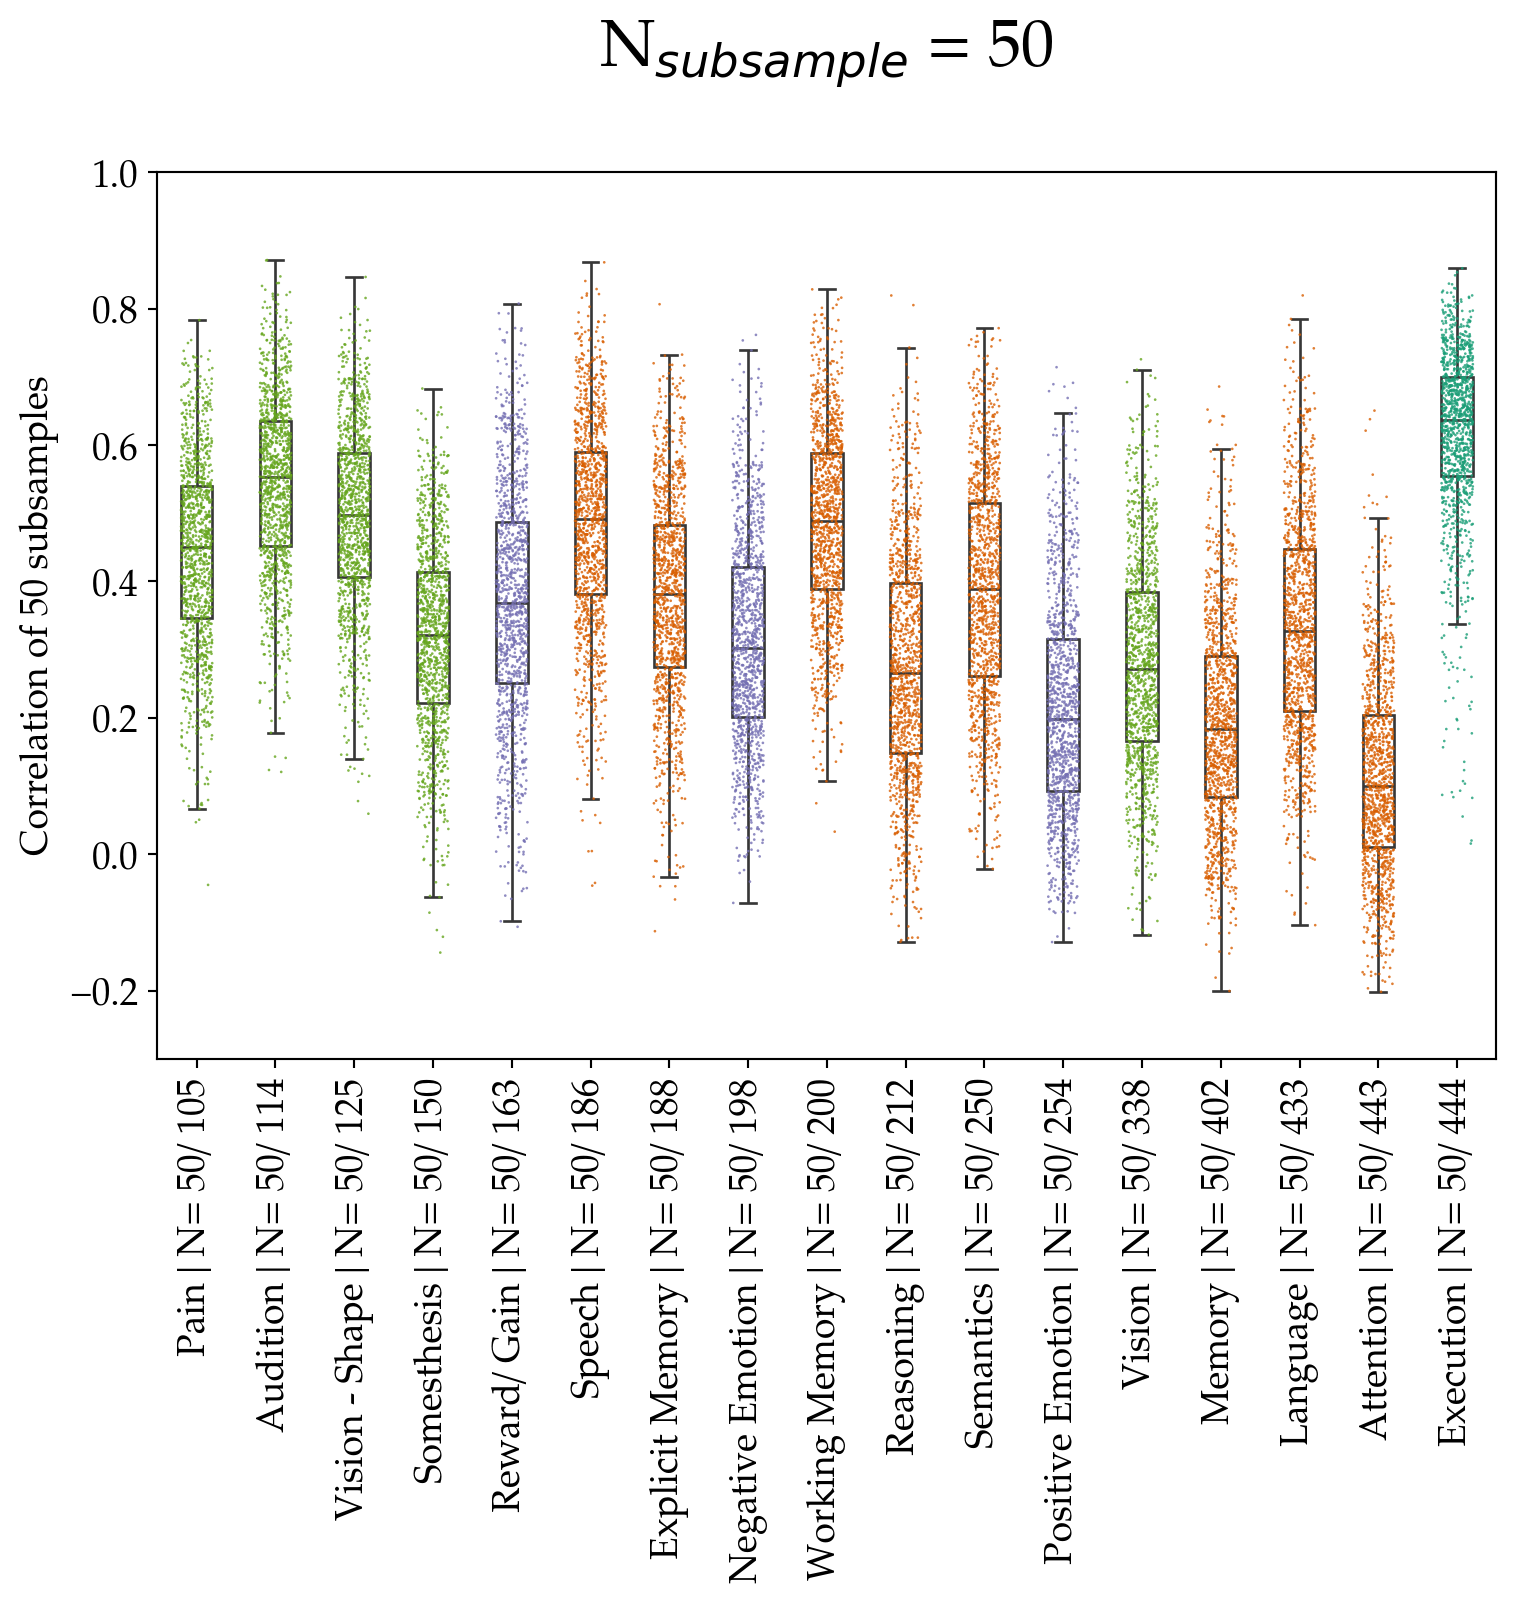

In [38]:
# Mapping each subdomain to the domain colors
subdomain_colors = {subdomain: domain_colors_dict[subdomain_domain_mapping[subdomain]] for subdomain in subdomain_domain_mapping}

# Plotting is as it was before

# Create a new figure
fig, ax = plt.subplots(figsize=(9, 6))

# Set backgrounds to transparent
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')

sns.stripplot(data=corrs_long, x='subdomain', y='corr', 
              order=subdomains_order, jitter=0.2,
              s=1, alpha=0.8, ax=ax, hue='subdomain', palette=subdomain_colors, legend=False) # Here we use the new colormapping.

sns.boxplot(data=corrs_long, x='subdomain', y='corr',
            order=subdomains_order,
            showfliers=False, showcaps=True, width=0.4,
            boxprops={"facecolor": (1, 1, 1, 1)}, ax=ax, hue='subdomain', palette=subdomain_colors, legend=False) # Here we use the new colormapping.

ax.set_xlabel('')
ax.set_ylabel('Correlation of 50 subsamples')
ax.set_title('N$_{subsample}$ = 50', y=1.1, fontsize=25)


ax.set_xticks(range(len(subdomains_order)))
ax.set_xticklabels([f'{subdomains_labels[subdomain]} | N= 50/ {subdomains_exps[subdomain]}' for subdomain in subdomains_order], rotation=90, ha='center')

ax.set_ylim([-0.3, 1])

plt.show()

In [41]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Stability_analyses/Figure3/Subdomains_SpatialCorrelations_N50.png'), bbox_inches='tight')

In [43]:
# Add the new data.
analysis = 'SALE'

for bd in BDs:
    for subdomain in subdomains:
        subsamples_dir = os.path.join(OUTPUT_DIR, analysis, bd, subdomain, 'subsamples_p-02')
        
        # Check if the directory exists before processing
        if os.path.exists(subsamples_dir):
            zmaps[analysis][subdomain] = []
            surf_zmaps[analysis][subdomain] = []
            
            for subsample in tqdm(range(50)):
                zmap_path = os.path.join(subsamples_dir, str(subsample), 'uncorr_z.nii.gz')
                
                # Check if the file exists before loading and adding to lists
                if os.path.exists(zmap_path):
                    zmaps[analysis][subdomain].append(nibabel.load(zmap_path))
                    surf_zmaps[analysis][subdomain].append(SUITPy.flatmap.vol_to_surf(zmap_path, space = 'SPM').squeeze()) # Space set to match BrainMap data.
                else:
                    print(f"File not found: {zmap_path}")
            
            # Convert to np.array only if data is present
            if surf_zmaps[analysis][subdomain]:
                surf_zmaps[analysis][subdomain] = np.array(surf_zmaps[analysis][subdomain])
            else:
                print(f"No data found for {bd} - {subdomain}")
        else:
            print(f"Directory not found: {subsamples_dir}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.25it/s]


Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Attention/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Language/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Language.Semantics/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Language.Speech/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Memory/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Memory.Explicit/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Memory.Working/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Cognition.Reasoning/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Action/Emotion.Negative/subsamples_p-02
Directory not found: /data/project/c

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.05it/s]


Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Emotion.Negative/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Emotion.Positive/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Emotion.Positive.RewardGain/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Audition/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Somesthesis/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Somesthesis.Pain/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Vision/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Cognition/Perception.Vision.Shape/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Action.Execution/subsamples_p-02
Directory not foun

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.37it/s]


Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Audition/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Somesthesis/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Somesthesis.Pain/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Vision/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Emotion/Perception.Vision.Shape/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Action.Execution/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Cognition.Attention/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Cognition.Language/subsamples_p-02
Directory not found: /data/project/cerebellum_ale/output/SALE/Interoception/Cognition.Language.Semantics/subsamples_p-02
Dire

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.54it/s]


In [48]:
# Create full correlation matrix
corrs[analysis] = {}
corrs_tril[analysis] = {}
for subdomain in subdomains:
    surf_data = surf_zmaps[analysis][subdomain]
    
    # Check if there is sufficient data for correlation
    if len(surf_data) > 1:
        # Calculate correlation matrix
        corr_matrix = np.corrcoef(surf_data)
        
        # Flatten the lower triangular part of the correlation matrix
        corrs_tril[analysis][subdomain] = corr_matrix[np.tril_indices(corr_matrix.shape[0], -1)]
        
        # Store the full correlation matrix
        corrs[analysis][subdomain] = corr_matrix
    else:
        print(f"Insufficient data for correlation calculation for {subdomain}")

In [49]:
# Transform to long format
corrs_long = pd.DataFrame(corrs_tril[analysis]).unstack().reset_index()
corrs_long.columns = ['subdomain', 'pair', 'corr']

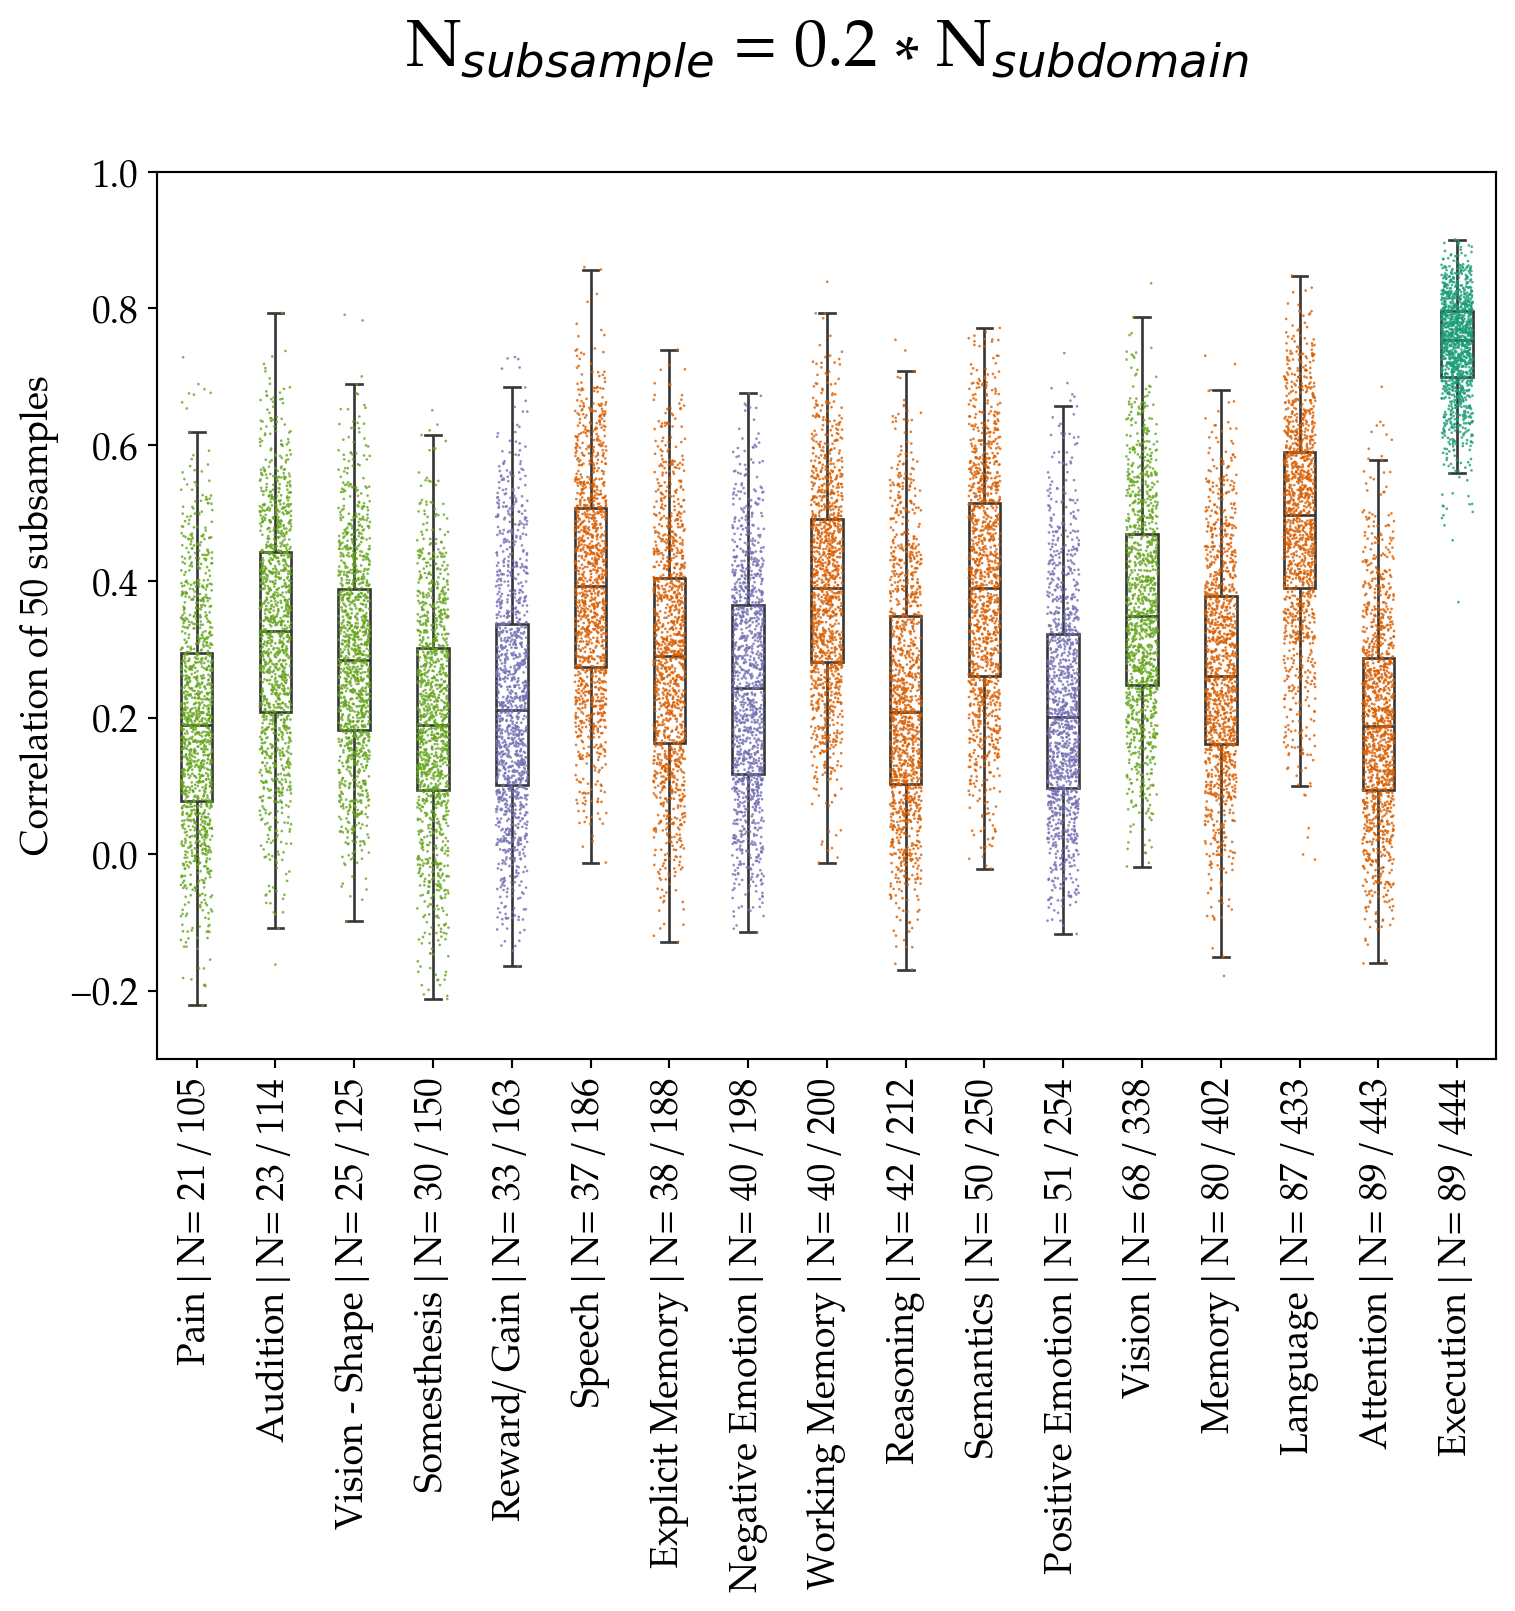

In [50]:
# Mapping each subdomain to the domain colors
subdomain_colors = {subdomain: domain_colors_dict[subdomain_domain_mapping[subdomain]] for subdomain in subdomain_domain_mapping}

# Plotting as it was before

# Create a new figure
fig, ax = plt.subplots(figsize=(9, 6))

# Set backgrounds to transparent
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')

sns.stripplot(data=corrs_long, x='subdomain', y='corr', 
              order=subdomains_order, jitter=0.2,
              s=1, alpha=0.8, ax=ax, hue='subdomain', palette=subdomain_colors, legend=False)

sns.boxplot(data=corrs_long, x='subdomain', y='corr',
            order=subdomains_order,
            showfliers=False, showcaps=True, width=0.4,
            boxprops={"facecolor": (1, 1, 1, 1)}, ax=ax, hue='subdomain', palette=subdomain_colors, legend=False)

ax.set_xlabel('')
ax.set_ylabel('Correlation of 50 subsamples')
ax.set_title('N$_{subsample}$ = 0.2 * N$_{subdomain}$', y=1.1, fontsize=25)


ax.set_xticks(range(len(subdomains_order)))
ax.set_xticklabels([f'{subdomains_labels[subdomain]} | N= {subdomains_exps_sample[subdomain]} / {subdomains_exps[subdomain]}' for subdomain in subdomains_order], rotation=90, ha='center')

ax.set_ylim([-0.3, 1])

plt.show()

In [51]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Stability_analyses/Figure3/Subdomains_SpatialCorrelations_p02.png'), bbox_inches='tight')

# For the sliding-proportion subsampling.
## We did this for all domains with N>= 20 (to have at least 20 studies per subsample in the 10 per cent proportion).

## **TO DO** ##

# Visualisation to show the percentage of subsamples that converge at every voxel per BD.

In [61]:
# Define a function to create the common SUITPy flatmap/ voxel heatmap.
def create_common_flatmap(surf_zmaps):
    # Total number of maps
    num_maps = len(surf_zmaps)
    
    # Print the shape of the first surf_map
    print("Shape of surf_zmaps[0]:", surf_zmaps[0].shape)
    
    # Initialize an empty array to store the count of subsamples per voxel
    count_subsamples = np.zeros_like(surf_zmaps[0])
    
    # Loop over each subsample map
    for surf_map in surf_zmaps:
        # Increment the count for each voxel where the value is greater than 0
        count_subsamples += (surf_map > 0)
    
    # Choose a random voxel and set its value to 100
    random_voxel = np.random.randint(0, count_subsamples.shape[0])
    count_subsamples[random_voxel] = 50 ## This is very hacky since it assigns a random voxel the maximum value of 50/50 subsamples. We can fix this by assigning this to a fixed location and correcting the color after!

        
    # Calculate the proportion of maps > 0 as a percentage
    percent_maps = (count_subsamples / num_maps) * 100
    
    # Plot the common flatmap
    flatmap.plot(percent_maps, colorbar=True, cmap='hot', bordersize=0.5, bordercolor='white', new_figure=False)

In [ ]:
# First, the N = 50 subsamples.
## We focus on thresholded (p < 0.001 and K = 50) maps.

In [56]:
# Add data.
analysis = 'SALE'
zmaps[analysis] = {}
surf_zmaps[analysis] = {}
for bd in BDs:
    zmaps[analysis][bd] = []
    surf_zmaps[analysis][bd] = []
    subsamples_dir = os.path.join(OUTPUT_DIR, analysis, bd, bd, 'subsamples')
    for subsample in tqdm(range(50)):
        zmap_path = os.path.join(subsamples_dir, str(subsample), 'corr_cluster_h-001_k-50_mask-D2009_MNI_z.nii.gz')
        zmaps[analysis][bd].append(nibabel.load(zmap_path))
        surf_zmaps[analysis][bd].append(SUITPy.flatmap.vol_to_surf(zmap_path, space = 'SPM').squeeze()) # Space to mathc BrainMap.
    surf_zmaps[analysis][bd] = np.array(surf_zmaps[analysis][bd])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.10it/s]


Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)


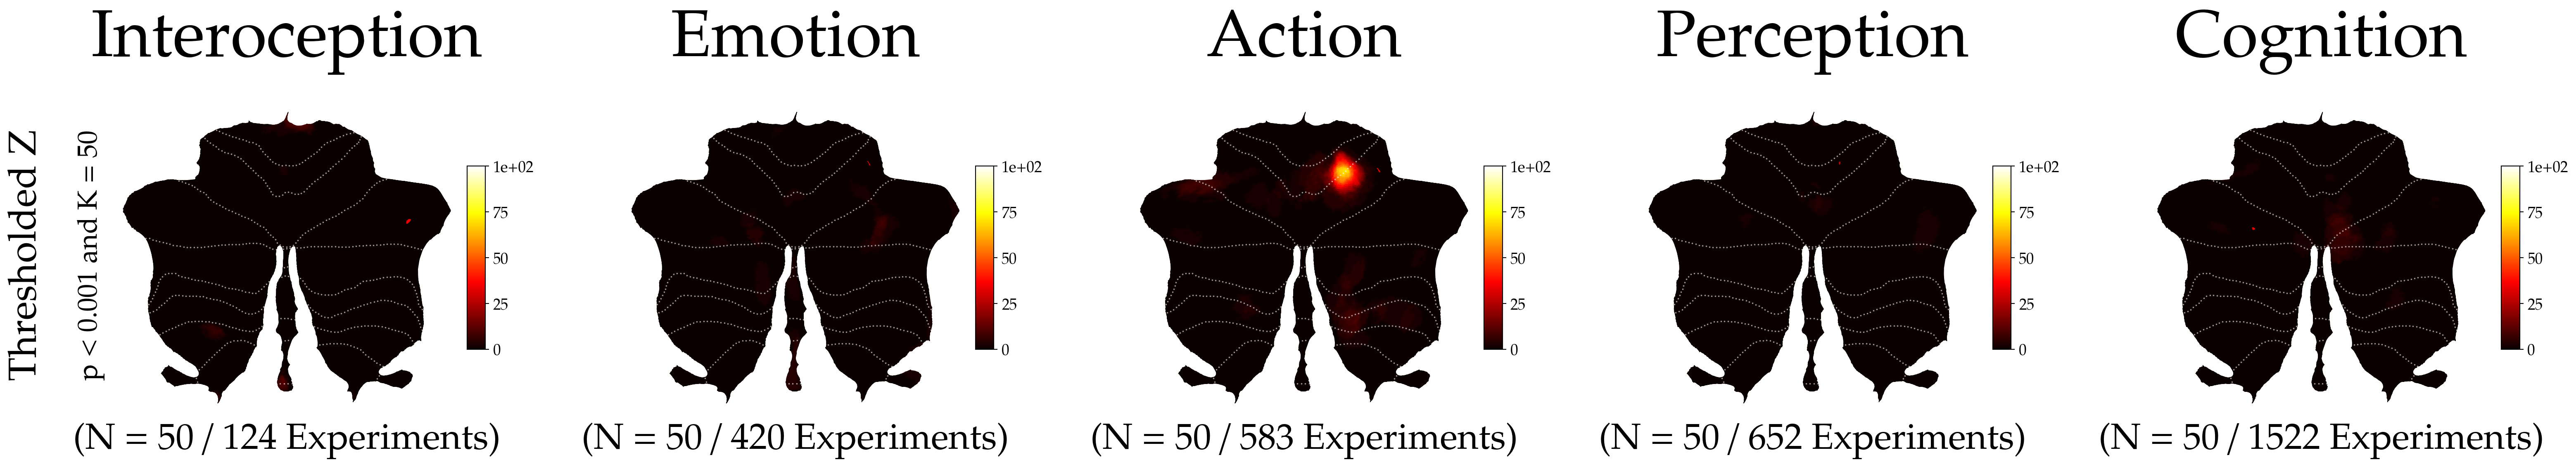

In [62]:
## Thresholded Z (p < 0.001 and K =50), N =  50 
fig = plt.figure(figsize=(40, 6))


# Loop over domains, creating plots that map the percentage of subsamples with values > 0 (voxel-by-voxel)
for i, bd in enumerate(BDs_order):
    ax = fig.add_subplot(1,5, i + 1)
    
    create_common_flatmap(surf_zmaps[analysis][bd])
    
    # Overlay the cluster borders on top
    #ax.plot(cluster_borders_dict[domain][:, 0], cluster_borders_dict[domain][:, 1], color='black',
           # marker='.', linestyle=None, markersize=0.01, linewidth=0)
    
    # Overlay the cluster borders on top
   # ax.plot(cluster_borders_dict_strict[domain][:, 0], cluster_borders_dict_strict[domain][:, 1], color='red',
          #  marker='.', linestyle=None, markersize=0.01, linewidth=0)

    # Set titles and labels as needed
    ax.set_title(f"{bd}", fontsize = 60)
    ax.text(0.5, 0.0, f'(N = 50 / {BDs_exps[bd]} Experiments)', fontsize=33, ha='center', va='center', transform=ax.transAxes)
    #ax.set_xlabel("X-axis Label")
    #ax.set_ylabel("Y-axis Label")

# Adjust layout
# plt.tight_layout()

# Add a y-axis label to the main plot
fig.text(0.1, 0.5, 'Thresholded Z', va='center', ha='center', rotation='vertical', fontsize=35)
fig.text (0.12, 0.5, 'p < 0.001 and K = 50', va='center', ha='center', rotation='vertical', fontsize = 25)
          
# Show the plot
plt.show()

In [63]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Stability_analyses/Figure3/Domains_voxel-heatmap_thres_N50.png'), bbox_inches='tight')

# Proportion = 0.2 subsampling

In [64]:
# Load data.
analysis = 'SALE'
zmaps[analysis] = {}
surf_zmaps[analysis] = {}
for bd in BDs:
    zmaps[analysis][bd] = []
    surf_zmaps[analysis][bd] = []
    subsamples_dir = os.path.join(OUTPUT_DIR, analysis, bd, bd, 'subsamples_p-02')
    for subsample in tqdm(range(50)):
        zmap_path = os.path.join(subsamples_dir, str(subsample), 'corr_cluster_h-001_k-50_mask-D2009_MNI_z.nii.gz')
        zmaps[analysis][bd].append(nibabel.load(zmap_path))
        surf_zmaps[analysis][bd].append(SUITPy.flatmap.vol_to_surf(zmap_path, space = 'SPM').squeeze()) # Space.
    surf_zmaps[analysis][bd] = np.array(surf_zmaps[analysis][bd])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.75it/s]


Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)
Shape of surf_zmaps[0]: (28935,)


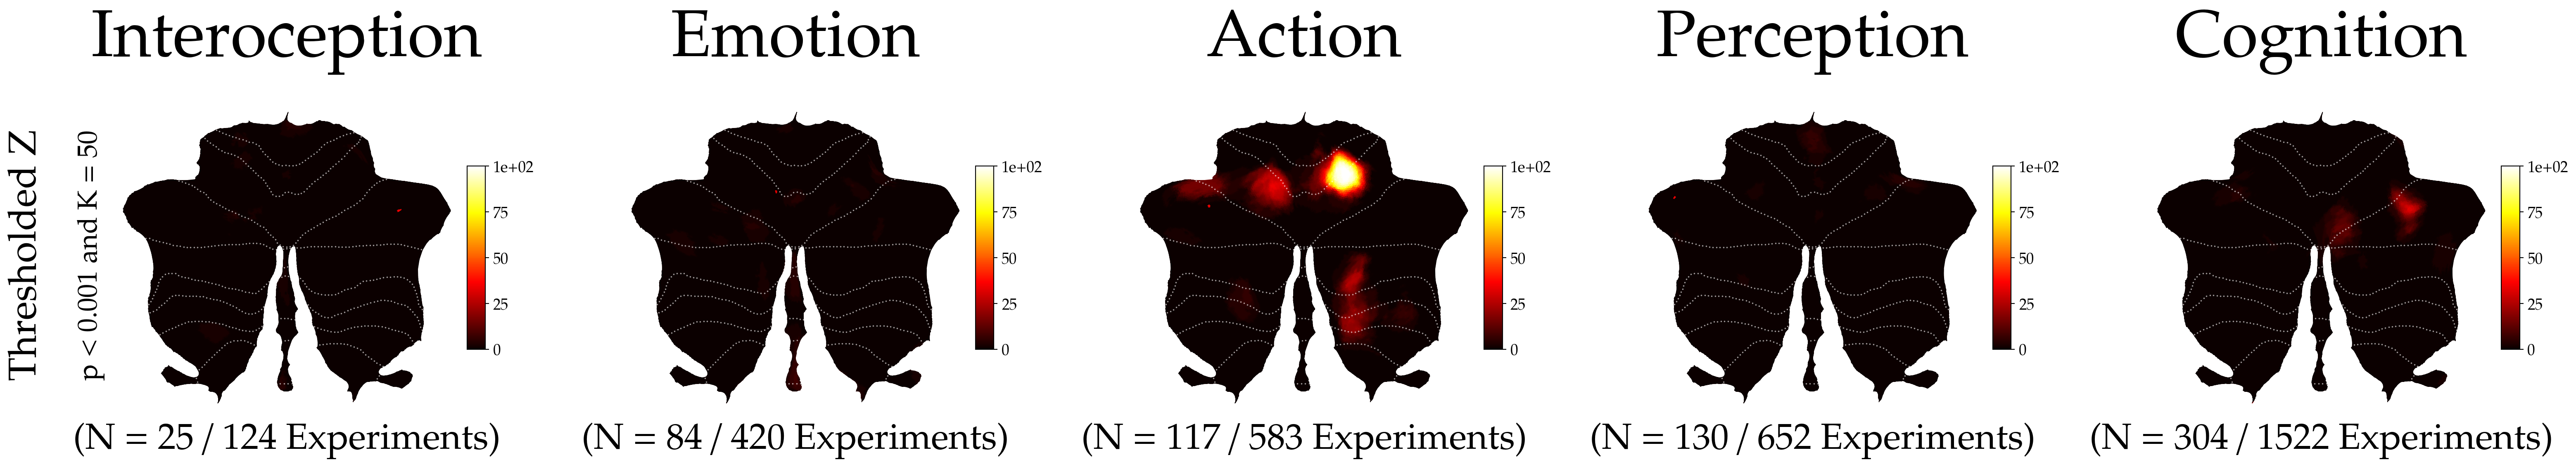

In [66]:
## Thresholded Z (p < 0.001 and K = 50), N =  0.2 * Ndomain

# Create a new figurte
fig = plt.figure(figsize=(40, 6))


# Loop over domains, creating plots that map the percentage of subsamples with values > 0 (voxel-by-voxel)
for i, bd in enumerate(BDs_order):
    ax = fig.add_subplot(1,5, i + 1)
    
    create_common_flatmap(surf_zmaps[analysis][bd])
    
    # Set titles and labels as needed
    ax.set_title(f"{bd}", fontsize = 60)
    ax.text(0.5, 0.0, f'(N = {BDs_exps_sample[bd]} / {BDs_exps[bd]} Experiments)', fontsize=33, ha='center', va='center', transform=ax.transAxes)

# Add a y-axis label to the main plot
fig.text(0.1, 0.5, 'Thresholded Z', va='center', ha='center', rotation='vertical', fontsize=35)
fig.text (0.12, 0.5, 'p < 0.001 and K = 50', va='center', ha='center', rotation='vertical', fontsize = 25)
          
# Show the plot
plt.show()

In [67]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/Stability_analyses/Figure3/Domains_voxel-heatmap_thres_02.png'), bbox_inches='tight')

# We can also visualize these heatmaps at split-half/ the largest subsample size.

## **TO DO**

# The End.